FD001

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import joblib
import math
import glob
import json

In [ ]:
# Cell 2: Upload CMAPSS files using code (Option 1)

from google.colab import files
import os
import glob

# Upload files (select train_FD001.txt, test_FD001.txt, RUL_FD001.txt)
uploaded = files.upload()

print("\nFiles uploaded:")
for f in uploaded.keys():
    print(f)

# Set DATA_DIR to current working directory
DATA_DIR = "."

# Verify CMAPSS files are visible
print("\nFD files found in working directory:")
print(sorted(glob.glob(os.path.join(DATA_DIR, "*FD*.txt"))))

Saving test_FD001.txt to test_FD001.txt
Saving train_FD001.txt to train_FD001.txt
Saving RUL_FD001.txt to RUL_FD001.txt

Files uploaded:
test_FD001.txt
train_FD001.txt
RUL_FD001.txt

FD files found in working directory:
['./RUL_FD001.txt', './test_FD001.txt', './train_FD001.txt']


In [ ]:
def read_cmapss(file_path):
    col_names = (
        ["unit", "cycle",
         "op_setting_1", "op_setting_2", "op_setting_3"] +
        [f"s{i}" for i in range(1, 22)]
    )
    return pd.read_csv(file_path, sep=r"\s+", header=None, names=col_names)

In [ ]:
train_file = os.path.join(DATA_DIR, "train_FD001.txt")
train_df = read_cmapss(train_file)

max_cycle = train_df.groupby("unit")["cycle"].max().reset_index()
max_cycle.columns = ["unit", "max_cycle"]

train_df = train_df.merge(max_cycle, on="unit", how="left")
train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]
train_df.drop("max_cycle", axis=1, inplace=True)

print(train_df.shape)
train_df.head()

(20631, 27)


,unit,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [ ]:
print("Number of units:", train_df["unit"].nunique())
print("\nMissing values per column:")
print(train_df.isna().sum())

Number of units: 100

Missing values per column:
unit            0
cycle           0
op_setting_1    0
op_setting_2    0
op_setting_3    0
s1              0
s2              0
s3              0
s4              0
s5              0
s6              0
s7              0
s8              0
s9              0
s10             0
s11             0
s12             0
s13             0
s14             0
s15             0
s16             0
s17             0
s18             0
s19             0
s20             0
s21             0
RUL             0
dtype: int64


In [ ]:
def preprocess_df(df, cap_rul=125):
    df = df.copy()
    df["RUL_capped"] = df["RUL"].clip(upper=cap_rul)

    sensor_cols = [c for c in df.columns if c.startswith("s") or c.startswith("op_setting")]

    scaler = StandardScaler()
    scaler.fit(df[sensor_cols])
    df[sensor_cols] = scaler.transform(df[sensor_cols])

    return df, scaler, sensor_cols

In [ ]:
train_df, scaler_fd001, sensor_cols = preprocess_df(train_df)
print("Sensor columns used:", sensor_cols[:8])

Sensor columns used: ['op_setting_1', 'op_setting_2', 'op_setting_3', 's1', 's2', 's3', 's4', 's5']


In [ ]:
def generate_sequences(df, seq_len=50, sensor_cols=None, label_col="RUL_capped"):
    X, y = [], []

    for u in sorted(df["unit"].unique()):
        tmp = df[df["unit"] == u].sort_values("cycle")
        data = tmp[sensor_cols].values
        labels = tmp[label_col].values

        if len(data) < seq_len:
            continue

        for i in range(len(data) - seq_len + 1):
            X.append(data[i:i+seq_len])
            y.append(labels[i+seq_len-1])

    return np.array(X), np.array(y)

In [ ]:
SEQ_LEN = 50
X, y = generate_sequences(train_df, SEQ_LEN, sensor_cols)

print(X.shape, y.shape)

(15731, 50, 24) (15731,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

Train: (13371, 50, 24) (13371,)
Val: (2360, 50, 24) (2360,)


In [ ]:
def build_gru_model(input_shape, units=128, dropout=0.3):
    model = Sequential([
        GRU(units, input_shape=input_shape),
        BatchNormalization(),
        Dropout(dropout),
        Dense(64, activation="relu"),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

In [ ]:
model = build_gru_model((SEQ_LEN, len(sensor_cols)))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        59,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,969 (265.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ModelCheckpoint("gru_fd001.h5", monitor="val_loss", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/30


105/105 - 18s - 172ms/step - loss: 3607.4080 - mae: 48.9114 - val_loss: 1506.2831 - val_mae: 32.0781
Epoch 2/30


105/105 - 14s - 136ms/step - loss: 634.5743 - mae: 20.0925 - val_loss: 579.9960 - val_mae: 18.7573
Epoch 3/30


105/105 - 14s - 137ms/step - loss: 546.2852 - mae: 18.4822 - val_loss: 434.9775 - val_mae: 15.9817
Epoch 4/30


105/105 - 17s - 164ms/step - loss: 362.0973 - mae: 14.8817 - val_loss: 258.2350 - val_mae: 12.5426
Epoch 5/30


105/105 - 14s - 136ms/step - loss: 324.1338 - mae: 14.1859 - val_loss: 196.3121 - val_mae: 10.8670
Epoch 6/30
105/105 - 21s - 196ms/step - loss: 284.6074 - mae: 13.2610 - val_loss: 223.9021 - val_mae: 11.4897
Epoch 7/30
105/105 - 20s - 193ms/step - loss: 260.6512 - mae: 12.5387 - val_loss: 228.0855 - val_mae: 11.3825
Epoch 8/30


105/105 - 14s - 136ms/step - loss: 233.8164 - mae: 11.9455 - val_loss: 150.3190 - val_mae: 9.3272
Epoch 9/30


105/105 - 14s - 135ms/step - loss: 208.6376 - mae: 11.2462 - val_loss: 143.4525 - val_mae: 8.9488
Epoch 10/30
105/105 - 14s - 135ms/step - loss: 205.1254 - mae: 11.0419 - val_loss: 146.9606 - val_mae: 9.0435
Epoch 11/30
105/105 - 15s - 142ms/step - loss: 199.3922 - mae: 10.9233 - val_loss: 169.7359 - val_mae: 9.8144
Epoch 12/30


105/105 - 15s - 140ms/step - loss: 193.0066 - mae: 10.6793 - val_loss: 117.2952 - val_mae: 8.0278
Epoch 13/30


105/105 - 20s - 190ms/step - loss: 189.6761 - mae: 10.6421 - val_loss: 116.7174 - val_mae: 8.2390
Epoch 14/30


105/105 - 20s - 195ms/step - loss: 179.6054 - mae: 10.3135 - val_loss: 114.7400 - val_mae: 7.9750
Epoch 15/30
105/105 - 21s - 201ms/step - loss: 192.1877 - mae: 10.6255 - val_loss: 162.4318 - val_mae: 9.9160
Epoch 16/30
105/105 - 20s - 189ms/step - loss: 191.0602 - mae: 10.6909 - val_loss: 150.9170 - val_mae: 9.5561
Epoch 17/30


105/105 - 14s - 135ms/step - loss: 167.1074 - mae: 9.8736 - val_loss: 103.5081 - val_mae: 7.8908
Epoch 18/30


105/105 - 14s - 135ms/step - loss: 155.5679 - mae: 9.5891 - val_loss: 97.6090 - val_mae: 7.4373
Epoch 19/30
105/105 - 21s - 195ms/step - loss: 166.9106 - mae: 9.9194 - val_loss: 103.0163 - val_mae: 7.7337
Epoch 20/30
105/105 - 14s - 135ms/step - loss: 169.2558 - mae: 9.9285 - val_loss: 352.9284 - val_mae: 14.3891
Epoch 21/30
105/105 - 15s - 141ms/step - loss: 152.6313 - mae: 9.5147 - val_loss: 155.4355 - val_mae: 9.4647
Epoch 22/30


105/105 - 15s - 140ms/step - loss: 139.5320 - mae: 9.0685 - val_loss: 94.2274 - val_mae: 7.4834
Epoch 23/30


105/105 - 15s - 142ms/step - loss: 138.2227 - mae: 9.0728 - val_loss: 82.7438 - val_mae: 6.7583
Epoch 24/30
105/105 - 20s - 189ms/step - loss: 132.4955 - mae: 8.8120 - val_loss: 106.1501 - val_mae: 7.4755
Epoch 25/30
105/105 - 14s - 136ms/step - loss: 137.2578 - mae: 8.9571 - val_loss: 83.0042 - val_mae: 6.9101
Epoch 26/30
105/105 - 15s - 142ms/step - loss: 116.6860 - mae: 8.2796 - val_loss: 91.5983 - val_mae: 7.3138
Epoch 27/30


105/105 - 14s - 138ms/step - loss: 112.1254 - mae: 8.1283 - val_loss: 69.1112 - val_mae: 6.2967
Epoch 28/30
105/105 - 15s - 145ms/step - loss: 113.8870 - mae: 8.2097 - val_loss: 121.6636 - val_mae: 8.4223
Epoch 29/30
105/105 - 14s - 135ms/step - loss: 106.6013 - mae: 7.9340 - val_loss: 118.5420 - val_mae: 8.2194
Epoch 30/30
105/105 - 14s - 136ms/step - loss: 109.6880 - mae: 8.0505 - val_loss: 84.2055 - val_mae: 7.2545


In [ ]:
joblib.dump(scaler_fd001, "scaler_fd001.joblib")

['scaler_fd001.joblib']

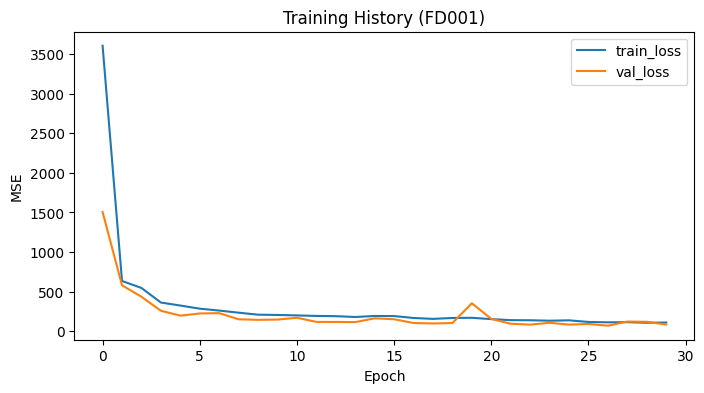

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training History (FD001)")
plt.show()

In [ ]:
y_val_pred = model.predict(X_val).ravel()
rmse_val = math.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE (FD001, capped): {rmse_val:.4f}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Validation RMSE (FD001, capped): 8.3133


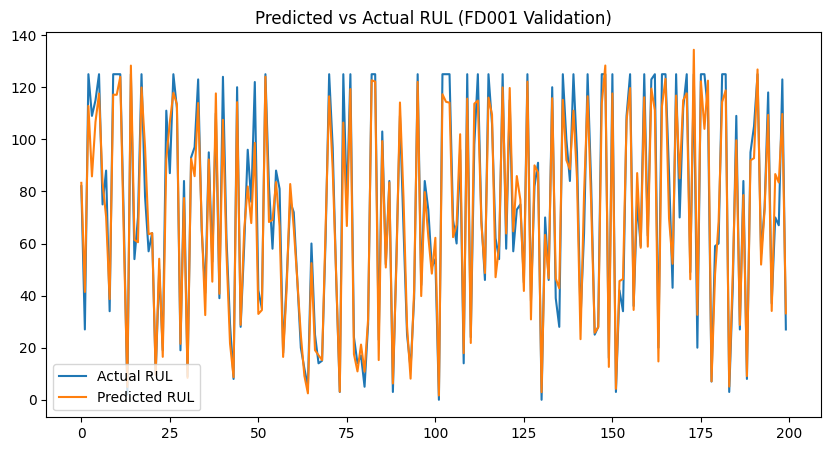

In [ ]:
idx = np.random.choice(len(y_val), size=min(200, len(y_val)), replace=False)

plt.figure(figsize=(10,5))
plt.plot(y_val[idx], label="Actual RUL")
plt.plot(y_val_pred[idx], label="Predicted RUL")
plt.legend()
plt.title("Predicted vs Actual RUL (FD001 Validation)")
plt.show()

In [ ]:
test_df = read_cmapss(os.path.join(DATA_DIR, "test_FD001.txt"))
rul_true = pd.read_csv(os.path.join(DATA_DIR, "RUL_FD001.txt"), sep=r"\s+", header=None).values.ravel()

test_df[sensor_cols] = scaler_fd001.transform(test_df[sensor_cols])

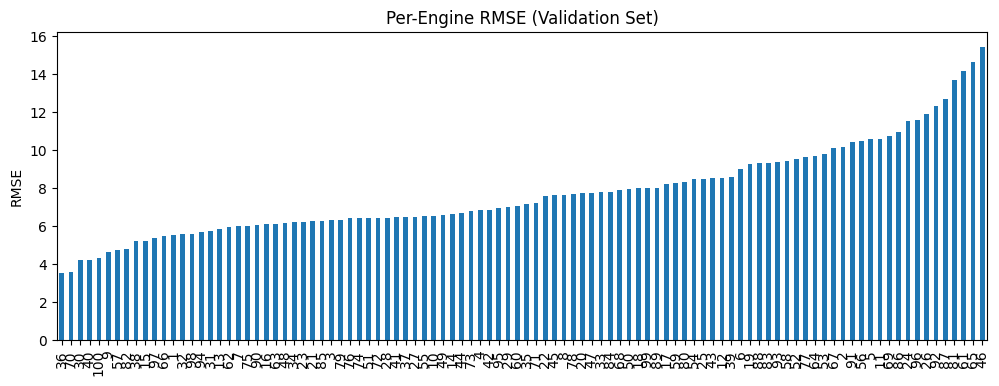

In [ ]:
engine_rmse_df.sort_values("RMSE").plot(
    kind="bar", figsize=(12,4), legend=False,
    title="Per-Engine RMSE (Validation Set)"
)
plt.ylabel("RMSE")
plt.show()

In [ ]:
X_test = []
test_units = sorted(test_df["unit"].unique())

for u in test_units:
    tmp = test_df[test_df["unit"] == u].sort_values("cycle")
    arr = tmp[sensor_cols].values

    if arr.shape[0] >= SEQ_LEN:
        X_test.append(arr[-SEQ_LEN:])
    else:
        pad = np.vstack([arr[0]] * (SEQ_LEN - arr.shape[0]))
        X_test.append(np.vstack([pad, arr]))

X_test = np.array(X_test)

In [ ]:
CAP_RUL = 125
y_test_true = np.clip(rul_true, None, CAP_RUL)

y_test_pred = model.predict(X_test).ravel()
rmse_test = math.sqrt(mean_squared_error(y_test_true, y_test_pred))

print(f"Test RMSE FD001 (capped): {rmse_test:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test RMSE FD001 (capped): 15.6126


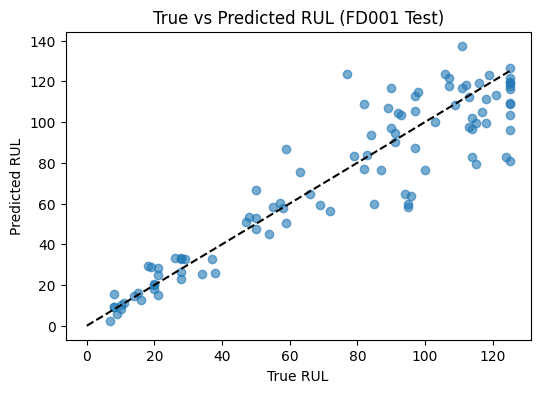

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(y_test_true, y_test_pred, alpha=0.6)
plt.plot([0, CAP_RUL], [0, CAP_RUL], "k--")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("True vs Predicted RUL (FD001 Test)")
plt.show()

In [ ]:
WARNING_THRESHOLD = 30
CRITICAL_THRESHOLD = 10

def get_alert(rul):
    if rul <= CRITICAL_THRESHOLD:
        return "CRITICAL"
    elif rul <= WARNING_THRESHOLD:
        return "WARNING"
    else:
        return "NORMAL"

print("Sample alerts (first 10 units):")
for i in range(10):
    print(f"Unit {test_units[i]} → Pred RUL={y_test_pred[i]:.1f}, Alert={get_alert(y_test_pred[i])}")

Sample alerts (first 10 units):
Unit 1 → Pred RUL=118.4, Alert=NORMAL
Unit 2 → Pred RUL=114.7, Alert=NORMAL
Unit 3 → Pred RUL=59.2, Alert=NORMAL
Unit 4 → Pred RUL=76.8, Alert=NORMAL
Unit 5 → Pred RUL=94.4, Alert=NORMAL
Unit 6 → Pred RUL=103.4, Alert=NORMAL
Unit 7 → Pred RUL=90.3, Alert=NORMAL
Unit 8 → Pred RUL=58.1, Alert=NORMAL
Unit 9 → Pred RUL=116.8, Alert=NORMAL
Unit 10 → Pred RUL=63.9, Alert=NORMAL


In [ ]:
# OPTIONAL: Per-engine absolute error on TEST set

test_engine_error = pd.DataFrame({
    "Unit": test_units,
    "True_RUL": y_test_true,
    "Predicted_RUL": y_test_pred,
})

test_engine_error["Absolute_Error"] = np.abs(
    test_engine_error["Predicted_RUL"] - test_engine_error["True_RUL"]
)

test_engine_error.head()

,Unit,True_RUL,Predicted_RUL,Absolute_Error
0,1,112,118.447533,6.447533
1,2,98,114.736954,16.736954
2,3,69,59.157921,9.842079
3,4,82,76.782410,5.217590
4,5,91,94.396690,3.396690


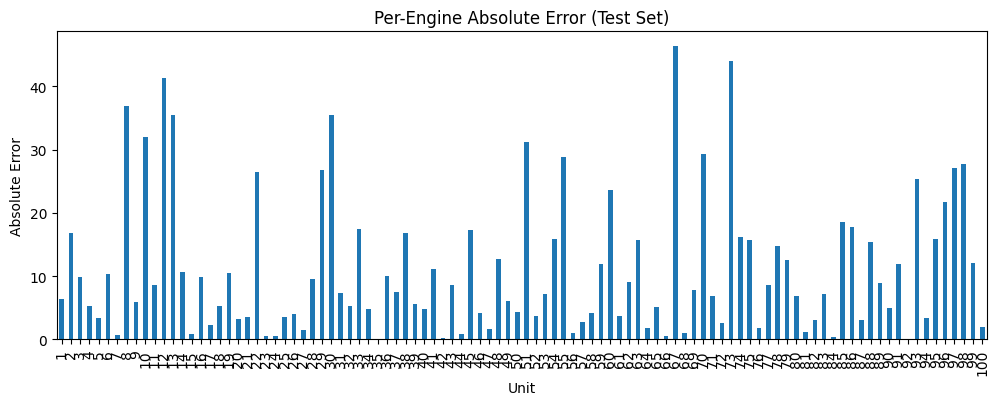

In [ ]:
test_engine_error.plot(
    x="Unit", y="Absolute_Error",
    kind="bar", figsize=(12,4), legend=False,
    title="Per-Engine Absolute Error (Test Set)"
)
plt.ylabel("Absolute Error")
plt.show()

FD002

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import joblib
import math
import glob

In [ ]:
from google.colab import files

uploaded = files.upload()

DATA_DIR = "."

print("Files found:")
print(sorted(glob.glob(os.path.join(DATA_DIR, "*FD002*.txt"))))

Saving test_FD002.txt to test_FD002.txt
Saving train_FD002.txt to train_FD002.txt
Saving RUL_FD002.txt to RUL_FD002.txt
Files found:
['./RUL_FD002.txt', './test_FD002.txt', './train_FD002.txt']


In [ ]:
def read_cmapss(file_path):
    cols = (
        ["unit", "cycle",
         "op_setting_1", "op_setting_2", "op_setting_3"] +
        [f"s{i}" for i in range(1, 22)]
    )
    return pd.read_csv(file_path, sep=r"\s+", header=None, names=cols)

In [ ]:
train_df = read_cmapss(os.path.join(DATA_DIR, "train_FD002.txt"))

max_cycle = train_df.groupby("unit")["cycle"].max().reset_index()
max_cycle.columns = ["unit", "max_cycle"]

train_df = train_df.merge(max_cycle, on="unit", how="left")
train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]
train_df.drop("max_cycle", axis=1, inplace=True)

print(train_df.shape)
train_df.head()

(53759, 27)


,unit,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


In [ ]:
print("Units:", train_df["unit"].nunique())
print("\nMissing values:")
print(train_df.isna().sum())

Units: 260

Missing values:
unit            0
cycle           0
op_setting_1    0
op_setting_2    0
op_setting_3    0
s1              0
s2              0
s3              0
s4              0
s5              0
s6              0
s7              0
s8              0
s9              0
s10             0
s11             0
s12             0
s13             0
s14             0
s15             0
s16             0
s17             0
s18             0
s19             0
s20             0
s21             0
RUL             0
dtype: int64


In [ ]:
def preprocess_df(df, cap_rul=125):
    df = df.copy()
    df["RUL_capped"] = df["RUL"].clip(upper=cap_rul)

    sensor_cols = [c for c in df.columns if c.startswith("s") or c.startswith("op_setting")]

    scaler = StandardScaler()
    scaler.fit(df[sensor_cols])
    df[sensor_cols] = scaler.transform(df[sensor_cols])

    return df, scaler, sensor_cols

In [ ]:
train_df, scaler_fd002, sensor_cols = preprocess_df(train_df)
print("Sensor columns:", sensor_cols[:6])

Sensor columns: ['op_setting_1', 'op_setting_2', 'op_setting_3', 's1', 's2', 's3']


In [ ]:
def generate_sequences(df, seq_len, sensor_cols, label_col="RUL_capped"):
    X, y, units = [], [], []
    for u in sorted(df["unit"].unique()):
        tmp = df[df["unit"] == u].sort_values("cycle")
        data = tmp[sensor_cols].values
        labels = tmp[label_col].values

        if len(data) < seq_len:
            continue

        for i in range(len(data) - seq_len + 1):
            X.append(data[i:i+seq_len])
            y.append(labels[i+seq_len-1])
            units.append(u)

    return np.array(X), np.array(y), np.array(units)

In [ ]:
SEQ_LEN = 50
X_all, y_all, unit_ids = generate_sequences(train_df, SEQ_LEN, sensor_cols)

print(X_all.shape, y_all.shape)

(41019, 50, 24) (41019,)


In [ ]:
X_train, X_val, y_train, y_val, units_train, units_val = train_test_split(
    X_all, y_all, unit_ids, test_size=0.15, random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)

Train: (34866, 50, 24)
Val: (6153, 50, 24)


In [ ]:
def build_gru(input_shape):
    model = Sequential([
        GRU(128, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

In [ ]:
model = build_gru((SEQ_LEN, len(sensor_cols)))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 128)            │        59,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,969 (265.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ModelCheckpoint("gru_fd002.h5", monitor="val_loss", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/30


273/273 - 42s - 153ms/step - loss: 2371.9604 - mae: 36.4928 - val_loss: 913.8543 - val_mae: 24.5074
Epoch 2/30


273/273 - 41s - 148ms/step - loss: 576.1628 - mae: 19.0305 - val_loss: 480.1682 - val_mae: 17.3955
Epoch 3/30
273/273 - 38s - 138ms/step - loss: 516.8637 - mae: 17.8773 - val_loss: 507.8678 - val_mae: 17.2237
Epoch 4/30
273/273 - 41s - 149ms/step - loss: 475.1320 - mae: 17.0238 - val_loss: 568.4301 - val_mae: 18.4729
Epoch 5/30


273/273 - 37s - 137ms/step - loss: 375.9070 - mae: 15.0861 - val_loss: 314.2129 - val_mae: 13.9133
Epoch 6/30


273/273 - 37s - 136ms/step - loss: 321.0027 - mae: 13.8727 - val_loss: 250.2081 - val_mae: 12.2751
Epoch 7/30
273/273 - 41s - 152ms/step - loss: 275.2558 - mae: 12.8089 - val_loss: 330.7424 - val_mae: 13.6089
Epoch 8/30


273/273 - 41s - 150ms/step - loss: 256.4285 - mae: 12.3169 - val_loss: 182.3899 - val_mae: 10.3625
Epoch 9/30
273/273 - 38s - 138ms/step - loss: 221.6933 - mae: 11.4636 - val_loss: 262.9305 - val_mae: 12.2246
Epoch 10/30


273/273 - 38s - 138ms/step - loss: 214.9890 - mae: 11.2923 - val_loss: 158.8779 - val_mae: 9.4784
Epoch 11/30
273/273 - 42s - 152ms/step - loss: 174.4715 - mae: 10.1969 - val_loss: 350.3752 - val_mae: 14.9733
Epoch 12/30
273/273 - 38s - 137ms/step - loss: 160.5905 - mae: 9.8078 - val_loss: 232.5944 - val_mae: 12.1297
Epoch 13/30


273/273 - 38s - 139ms/step - loss: 146.3385 - mae: 9.3670 - val_loss: 68.6251 - val_mae: 6.3493
Epoch 14/30
273/273 - 41s - 150ms/step - loss: 135.1317 - mae: 9.0145 - val_loss: 125.1589 - val_mae: 8.7687
Epoch 15/30


273/273 - 37s - 137ms/step - loss: 120.9091 - mae: 8.5247 - val_loss: 54.5111 - val_mae: 5.8349
Epoch 16/30
273/273 - 37s - 137ms/step - loss: 111.8923 - mae: 8.1914 - val_loss: 109.4814 - val_mae: 8.0834
Epoch 17/30
273/273 - 37s - 136ms/step - loss: 110.8291 - mae: 8.1797 - val_loss: 74.7100 - val_mae: 6.7889
Epoch 18/30
273/273 - 36s - 134ms/step - loss: 105.9249 - mae: 7.9759 - val_loss: 116.7771 - val_mae: 8.8177
Epoch 19/30


273/273 - 38s - 138ms/step - loss: 98.9725 - mae: 7.7058 - val_loss: 47.9684 - val_mae: 5.3214
Epoch 20/30


273/273 - 37s - 137ms/step - loss: 92.2467 - mae: 7.4630 - val_loss: 34.9421 - val_mae: 4.5377
Epoch 21/30
273/273 - 41s - 149ms/step - loss: 87.1288 - mae: 7.2417 - val_loss: 63.2349 - val_mae: 6.2049
Epoch 22/30
273/273 - 37s - 137ms/step - loss: 87.5328 - mae: 7.2441 - val_loss: 42.1508 - val_mae: 5.0473
Epoch 23/30
273/273 - 37s - 137ms/step - loss: 80.7858 - mae: 6.9702 - val_loss: 36.2176 - val_mae: 4.5858
Epoch 24/30


273/273 - 41s - 150ms/step - loss: 80.9381 - mae: 6.9751 - val_loss: 34.6220 - val_mae: 4.5905
Epoch 25/30
273/273 - 40s - 146ms/step - loss: 76.3445 - mae: 6.7806 - val_loss: 43.9275 - val_mae: 5.2048
Epoch 26/30


273/273 - 42s - 155ms/step - loss: 73.8587 - mae: 6.6719 - val_loss: 31.5569 - val_mae: 4.2600
Epoch 27/30
273/273 - 37s - 137ms/step - loss: 71.7771 - mae: 6.5660 - val_loss: 36.9687 - val_mae: 4.7473
Epoch 28/30


273/273 - 37s - 134ms/step - loss: 69.1500 - mae: 6.4317 - val_loss: 24.9889 - val_mae: 3.8849
Epoch 29/30


273/273 - 37s - 136ms/step - loss: 66.6074 - mae: 6.3211 - val_loss: 24.3061 - val_mae: 3.7289
Epoch 30/30


273/273 - 38s - 138ms/step - loss: 67.6004 - mae: 6.3250 - val_loss: 23.4689 - val_mae: 3.7042


In [ ]:
joblib.dump(scaler_fd002, "scaler_fd002.joblib")

['scaler_fd002.joblib']

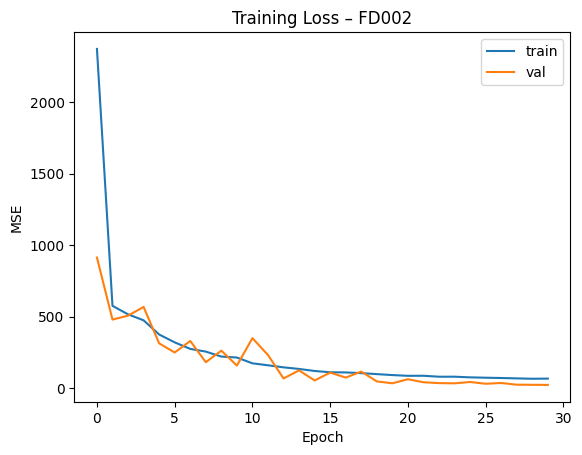

In [ ]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training Loss – FD002")
plt.show()

In [ ]:
y_val_pred = model.predict(X_val).ravel()
rmse_val = math.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Validation RMSE (FD002, capped): {rmse_val:.4f}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Validation RMSE (FD002, capped): 4.8445


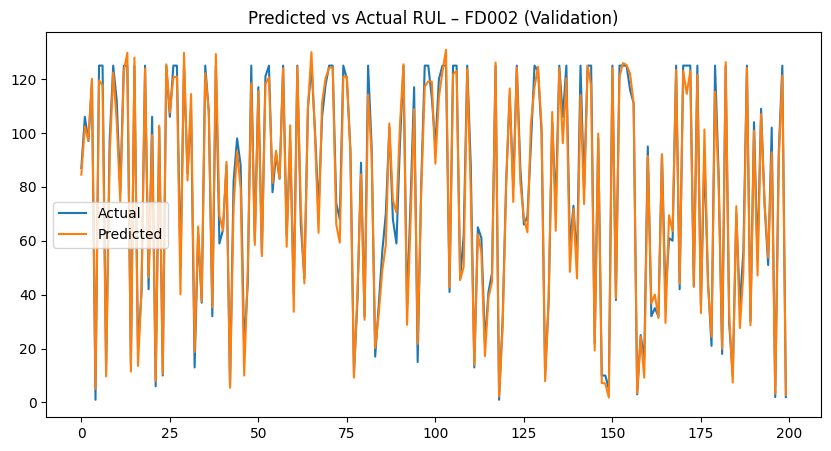

In [ ]:
idx = np.random.choice(len(y_val), size=min(200, len(y_val)), replace=False)

plt.figure(figsize=(10,5))
plt.plot(y_val[idx], label="Actual")
plt.plot(y_val_pred[idx], label="Predicted")
plt.legend()
plt.title("Predicted vs Actual RUL – FD002 (Validation)")
plt.show()

In [ ]:
engine_rmse = {}

for u in np.unique(units_val):
    idx = units_val == u
    engine_rmse[u] = np.sqrt(mean_squared_error(y_val[idx], y_val_pred[idx]))

engine_rmse_df = pd.DataFrame.from_dict(engine_rmse, orient="index", columns=["RMSE"])
engine_rmse_df.head()

,RMSE
1,5.553296
2,6.305885
3,3.708189
4,4.448381
5,7.433022


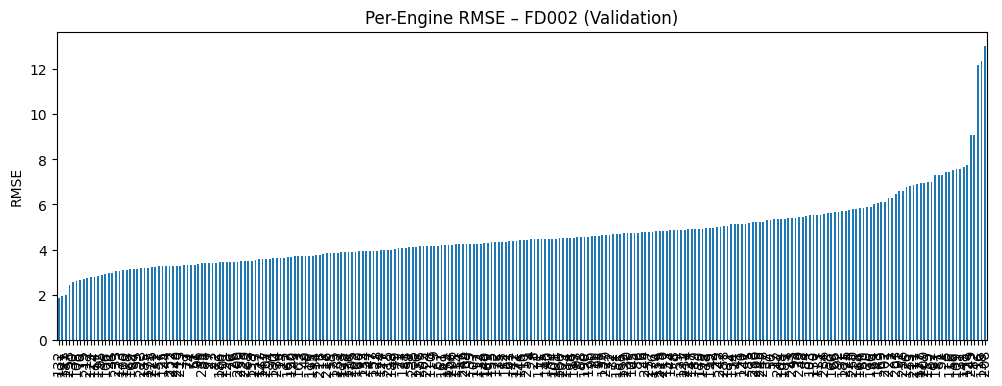

In [ ]:
engine_rmse_df.sort_values("RMSE").plot(
    kind="bar", figsize=(12,4), legend=False,
    title="Per-Engine RMSE – FD002 (Validation)"
)
plt.ylabel("RMSE")
plt.show()

In [ ]:
test_df = read_cmapss(os.path.join(DATA_DIR, "test_FD002.txt"))
rul_true = pd.read_csv(os.path.join(DATA_DIR, "RUL_FD002.txt"), sep=r"\s+", header=None).values.ravel()

test_df[sensor_cols] = scaler_fd002.transform(test_df[sensor_cols])

In [ ]:
X_test = []
test_units = sorted(test_df["unit"].unique())

for u in test_units:
    tmp = test_df[test_df["unit"] == u].sort_values("cycle")
    arr = tmp[sensor_cols].values

    if arr.shape[0] >= SEQ_LEN:
        X_test.append(arr[-SEQ_LEN:])
    else:
        pad = np.vstack([arr[0]] * (SEQ_LEN - arr.shape[0]))
        X_test.append(np.vstack([pad, arr]))

X_test = np.array(X_test)

In [ ]:
CAP_RUL = 125
y_test_true = np.clip(rul_true, None, CAP_RUL)

y_test_pred = model.predict(X_test).ravel()
rmse_test = math.sqrt(mean_squared_error(y_test_true, y_test_pred))

print(f"Test RMSE FD002 (capped): {rmse_test:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test RMSE FD002 (capped): 20.1205


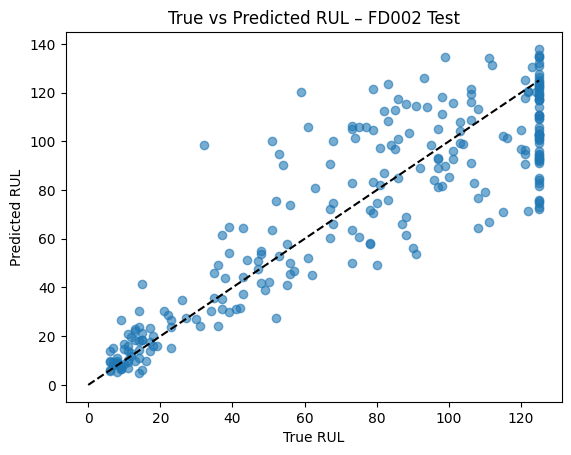

In [ ]:
plt.scatter(y_test_true, y_test_pred, alpha=0.6)
plt.plot([0, CAP_RUL], [0, CAP_RUL], "k--")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("True vs Predicted RUL – FD002 Test")
plt.show()

In [ ]:
WARNING = 30
CRITICAL = 10

def risk_label(rul):
    if rul <= CRITICAL:
        return "CRITICAL"
    elif rul <= WARNING:
        return "WARNING"
    else:
        return "NORMAL"

In [ ]:
for i in range(10):
    print(f"Unit {test_units[i]} → Pred={y_test_pred[i]:.1f}, Risk={risk_label(y_test_pred[i])}")

Unit 1 → Pred=16.1, Risk=WARNING
Unit 2 → Pred=104.8, Risk=NORMAL
Unit 3 → Pred=91.2, Risk=NORMAL
Unit 4 → Pred=79.3, Risk=NORMAL
Unit 5 → Pred=18.6, Risk=WARNING
Unit 6 → Pred=122.2, Risk=NORMAL
Unit 7 → Pred=9.3, Risk=CRITICAL
Unit 8 → Pred=56.2, Risk=NORMAL
Unit 9 → Pred=10.3, Risk=WARNING
Unit 10 → Pred=121.7, Risk=NORMAL


In [ ]:
def dynamic_thresholds(op_mode="normal"):
    if op_mode == "high_stress":
        return {"WARNING": 50, "CRITICAL": 20}
    else:
        return {"WARNING": 30, "CRITICAL": 10}

In [ ]:
thresholds = dynamic_thresholds("normal")

def dynamic_risk(rul):
    if rul <= thresholds["CRITICAL"]:
        return "CRITICAL"
    elif rul <= thresholds["WARNING"]:
        return "WARNING"
    else:
        return "NORMAL"

pd.Series([dynamic_risk(r) for r in y_test_pred]).value_counts()

,count
NORMAL,198
WARNING,39
CRITICAL,22


FD003

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import joblib
import math
import glob

In [ ]:
from google.colab import files

uploaded = files.upload()

DATA_DIR = "."

print("Files found:")
print(sorted(glob.glob(os.path.join(DATA_DIR, "*FD003*.txt"))))

Saving test_FD003.txt to test_FD003.txt
Saving train_FD003.txt to train_FD003.txt
Saving RUL_FD003.txt to RUL_FD003.txt
Files found:
['./RUL_FD003.txt', './test_FD003.txt', './train_FD003.txt']


In [ ]:
def read_cmapss(file_path):
    cols = (
        ["unit", "cycle",
         "op_setting_1", "op_setting_2", "op_setting_3"] +
        [f"s{i}" for i in range(1, 22)]
    )
    return pd.read_csv(file_path, sep=r"\s+", header=None, names=cols)

In [ ]:
train_df = read_cmapss(os.path.join(DATA_DIR, "train_FD003.txt"))

max_cycle = train_df.groupby("unit")["cycle"].max().reset_index()
max_cycle.columns = ["unit", "max_cycle"]

train_df = train_df.merge(max_cycle, on="unit", how="left")
train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]
train_df.drop("max_cycle", axis=1, inplace=True)

print(train_df.shape)
train_df.head()

(24720, 27)


,unit,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [ ]:
print("Units:", train_df["unit"].nunique())
print("\nMissing values:")
print(train_df.isna().sum())


Units: 100

Missing values:
unit            0
cycle           0
op_setting_1    0
op_setting_2    0
op_setting_3    0
s1              0
s2              0
s3              0
s4              0
s5              0
s6              0
s7              0
s8              0
s9              0
s10             0
s11             0
s12             0
s13             0
s14             0
s15             0
s16             0
s17             0
s18             0
s19             0
s20             0
s21             0
RUL             0
dtype: int64


In [ ]:
def preprocess_df(df, cap_rul=125):
    df = df.copy()
    df["RUL_capped"] = df["RUL"].clip(upper=cap_rul)

    sensor_cols = [c for c in df.columns if c.startswith("s") or c.startswith("op_setting")]

    scaler = StandardScaler()
    scaler.fit(df[sensor_cols])
    df[sensor_cols] = scaler.transform(df[sensor_cols])

    return df, scaler, sensor_cols


In [ ]:
train_df, scaler_fd003, sensor_cols = preprocess_df(train_df)
print("Sensor columns:", sensor_cols[:6])


Sensor columns: ['op_setting_1', 'op_setting_2', 'op_setting_3', 's1', 's2', 's3']


In [ ]:
def generate_sequences(df, seq_len, sensor_cols, label_col="RUL_capped"):
    X, y, units = [], [], []
    for u in sorted(df["unit"].unique()):
        tmp = df[df["unit"] == u].sort_values("cycle")
        data = tmp[sensor_cols].values
        labels = tmp[label_col].values

        if len(data) < seq_len:
            continue

        for i in range(len(data) - seq_len + 1):
            X.append(data[i:i+seq_len])
            y.append(labels[i+seq_len-1])
            units.append(u)

    return np.array(X), np.array(y), np.array(units)


In [ ]:
SEQ_LEN = 50
X_all, y_all, unit_ids = generate_sequences(train_df, SEQ_LEN, sensor_cols)

print(X_all.shape, y_all.shape)


(19820, 50, 24) (19820,)


In [ ]:
X_train, X_val, y_train, y_val, units_train, units_val = train_test_split(
    X_all, y_all, unit_ids, test_size=0.15, random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)


Train: (16847, 50, 24)
Val: (2973, 50, 24)


In [ ]:
def build_gru(input_shape):
    model = Sequential([
        GRU(128, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model


In [ ]:
model = build_gru((SEQ_LEN, len(sensor_cols)))
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 128)            │        59,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,969 (265.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ModelCheckpoint("gru_fd003.h5", monitor="val_loss", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/30


132/132 - 21s - 156ms/step - loss: 3698.4841 - mae: 48.4060 - val_loss: 673.4155 - val_mae: 18.4230
Epoch 2/30
132/132 - 19s - 147ms/step - loss: 1324.1753 - mae: 27.3889 - val_loss: 1200.0204 - val_mae: 29.1367
Epoch 3/30


132/132 - 18s - 135ms/step - loss: 413.9563 - mae: 15.7789 - val_loss: 294.4735 - val_mae: 11.8786
Epoch 4/30


132/132 - 21s - 157ms/step - loss: 386.0856 - mae: 15.1245 - val_loss: 243.3022 - val_mae: 11.5039
Epoch 5/30
132/132 - 18s - 133ms/step - loss: 402.1085 - mae: 15.5920 - val_loss: 638.0258 - val_mae: 20.1161
Epoch 6/30


132/132 - 19s - 144ms/step - loss: 386.7087 - mae: 14.9589 - val_loss: 236.6010 - val_mae: 11.0890
Epoch 7/30
132/132 - 17s - 132ms/step - loss: 369.7087 - mae: 14.6706 - val_loss: 329.3277 - val_mae: 15.5466
Epoch 8/30
132/132 - 18s - 135ms/step - loss: 348.3304 - mae: 14.2315 - val_loss: 271.1769 - val_mae: 13.8147
Epoch 9/30
132/132 - 20s - 154ms/step - loss: 554.4931 - mae: 17.5298 - val_loss: 16638.3633 - val_mae: 114.0235
Epoch 10/30
132/132 - 19s - 147ms/step - loss: 500.9663 - mae: 17.5556 - val_loss: 989.9853 - val_mae: 27.2613
Epoch 11/30
132/132 - 18s - 136ms/step - loss: 362.3690 - mae: 14.8596 - val_loss: 370.0992 - val_mae: 14.8953
Epoch 12/30


132/132 - 18s - 133ms/step - loss: 355.7136 - mae: 14.7392 - val_loss: 193.8240 - val_mae: 10.2691
Epoch 13/30
132/132 - 19s - 147ms/step - loss: 524.6196 - mae: 17.5982 - val_loss: 779.9388 - val_mae: 23.0953
Epoch 14/30
132/132 - 19s - 145ms/step - loss: 333.9111 - mae: 14.2750 - val_loss: 233.5654 - val_mae: 10.9897
Epoch 15/30


132/132 - 20s - 152ms/step - loss: 288.1557 - mae: 13.1900 - val_loss: 159.0737 - val_mae: 8.9927
Epoch 16/30
132/132 - 18s - 133ms/step - loss: 264.9433 - mae: 12.5524 - val_loss: 187.5896 - val_mae: 10.0662
Epoch 17/30


132/132 - 19s - 144ms/step - loss: 253.1229 - mae: 12.2239 - val_loss: 142.1010 - val_mae: 8.4697
Epoch 18/30


132/132 - 18s - 135ms/step - loss: 232.5294 - mae: 11.7461 - val_loss: 135.7603 - val_mae: 8.2174
Epoch 19/30


132/132 - 19s - 142ms/step - loss: 218.3096 - mae: 11.3762 - val_loss: 111.3979 - val_mae: 7.6991
Epoch 20/30
132/132 - 18s - 136ms/step - loss: 208.0159 - mae: 11.0852 - val_loss: 120.6712 - val_mae: 8.1342
Epoch 21/30
132/132 - 23s - 171ms/step - loss: 210.5332 - mae: 11.1087 - val_loss: 116.4254 - val_mae: 8.0966
Epoch 22/30


132/132 - 18s - 136ms/step - loss: 197.8549 - mae: 10.7068 - val_loss: 96.5291 - val_mae: 6.9726
Epoch 23/30
132/132 - 19s - 146ms/step - loss: 186.9352 - mae: 10.3662 - val_loss: 101.5610 - val_mae: 6.9806
Epoch 24/30


132/132 - 18s - 136ms/step - loss: 184.6850 - mae: 10.3346 - val_loss: 92.8372 - val_mae: 7.0637
Epoch 25/30
132/132 - 17s - 132ms/step - loss: 179.0724 - mae: 10.1360 - val_loss: 104.7244 - val_mae: 7.7124
Epoch 26/30
132/132 - 19s - 143ms/step - loss: 174.6768 - mae: 10.0689 - val_loss: 96.0826 - val_mae: 7.0875
Epoch 27/30


132/132 - 18s - 133ms/step - loss: 170.5737 - mae: 9.9001 - val_loss: 91.0798 - val_mae: 6.9494
Epoch 28/30


132/132 - 19s - 144ms/step - loss: 167.9340 - mae: 9.8271 - val_loss: 88.5435 - val_mae: 6.7294
Epoch 29/30
132/132 - 18s - 135ms/step - loss: 183.1171 - mae: 10.2285 - val_loss: 379.1425 - val_mae: 15.1903
Epoch 30/30
132/132 - 18s - 133ms/step - loss: 184.2751 - mae: 10.2997 - val_loss: 98.9338 - val_mae: 7.1671


In [ ]:
joblib.dump(scaler_fd003, "scaler_fd003.joblib")


['scaler_fd003.joblib']

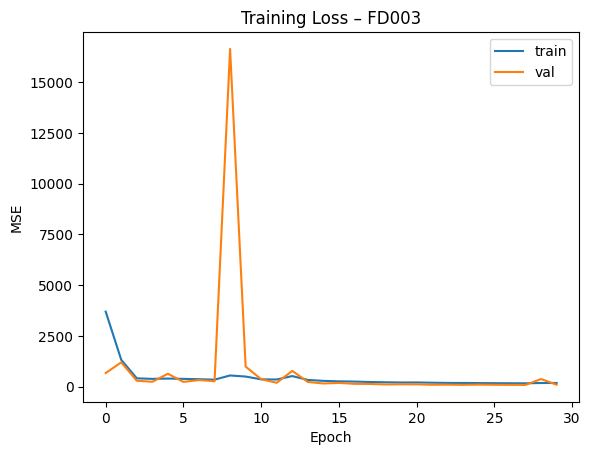

In [ ]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training Loss – FD003")
plt.show()


In [ ]:
y_val_pred = model.predict(X_val).ravel()
rmse_val = math.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Validation RMSE (FD003, capped): {rmse_val:.4f}")


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Validation RMSE (FD003, capped): 9.4098


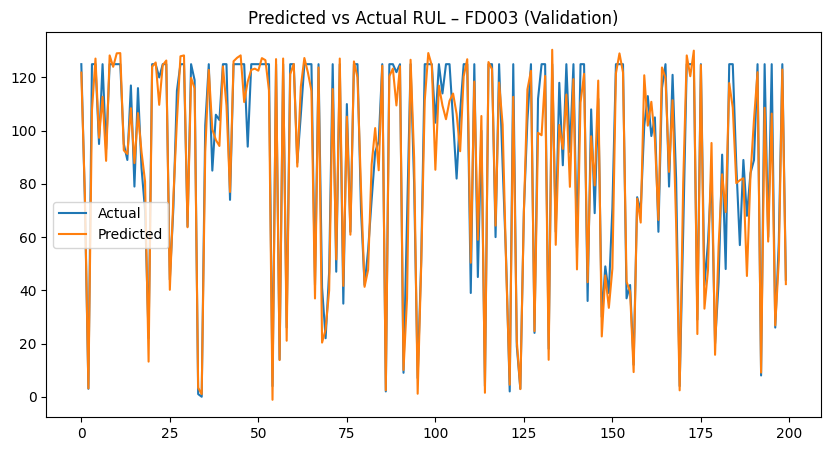

In [ ]:
idx = np.random.choice(len(y_val), size=min(200, len(y_val)), replace=False)

plt.figure(figsize=(10,5))
plt.plot(y_val[idx], label="Actual")
plt.plot(y_val_pred[idx], label="Predicted")
plt.legend()
plt.title("Predicted vs Actual RUL – FD003 (Validation)")
plt.show()


In [ ]:
engine_rmse = {}

for u in np.unique(units_val):
    idx = units_val == u
    engine_rmse[u] = np.sqrt(mean_squared_error(y_val[idx], y_val_pred[idx]))

engine_rmse_df = pd.DataFrame.from_dict(engine_rmse, orient="index", columns=["RMSE"])
engine_rmse_df.head()


,RMSE
1,12.333933
2,9.571630
3,8.130564
4,13.529459
5,9.226489


In [ ]:
test_df = read_cmapss(os.path.join(DATA_DIR, "test_FD003.txt"))
rul_true = pd.read_csv(os.path.join(DATA_DIR, "RUL_FD003.txt"),
                       sep=r"\s+", header=None).values.ravel()

test_df[sensor_cols] = scaler_fd003.transform(test_df[sensor_cols])


In [ ]:
X_test = []
test_units = sorted(test_df["unit"].unique())

for u in test_units:
    tmp = test_df[test_df["unit"] == u].sort_values("cycle")
    arr = tmp[sensor_cols].values

    if arr.shape[0] >= SEQ_LEN:
        X_test.append(arr[-SEQ_LEN:])
    else:
        pad = np.vstack([arr[0]] * (SEQ_LEN - arr.shape[0]))
        X_test.append(np.vstack([pad, arr]))

X_test = np.array(X_test)


In [ ]:
CAP_RUL = 125
y_test_true = np.clip(rul_true, None, CAP_RUL)

y_test_pred = model.predict(X_test).ravel()
rmse_test = math.sqrt(mean_squared_error(y_test_true, y_test_pred))

print(f"Test RMSE FD003 (capped): {rmse_test:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test RMSE FD003 (capped): 12.5666


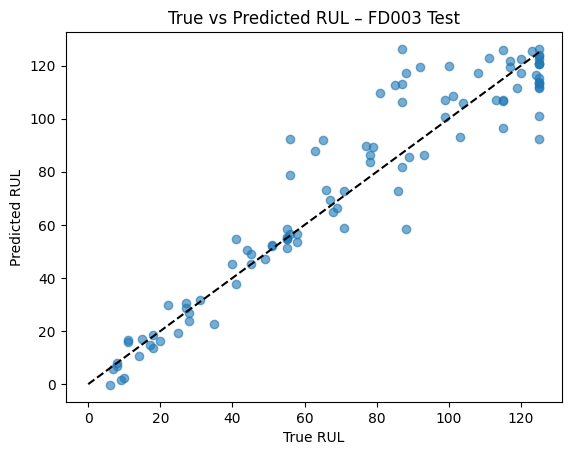

In [ ]:
plt.scatter(y_test_true, y_test_pred, alpha=0.6)
plt.plot([0, CAP_RUL], [0, CAP_RUL], "k--")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("True vs Predicted RUL – FD003 Test")
plt.show()


In [ ]:
# CELL 19A: Dynamic risk thresholds (bonus / industrial extension)

def dynamic_thresholds(op_mode="normal"):
    if op_mode == "high_stress":
        return {"WARNING": 50, "CRITICAL": 20}
    else:
        return {"WARNING": 30, "CRITICAL": 10}

# Example operating mode (can be inferred later from op settings)
operating_mode = "normal"
thresholds = dynamic_thresholds(operating_mode)

def dynamic_risk_label(rul):
    if rul <= thresholds["CRITICAL"]:
        return "CRITICAL"
    elif rul <= thresholds["WARNING"]:
        return "WARNING"
    else:
        return "NORMAL"

# Apply dynamic risk labeling
risk_labels_dynamic = [dynamic_risk_label(r) for r in y_test_pred]

risk_summary_dynamic = pd.DataFrame({
    "Unit": test_units,
    "Predicted_RUL": y_test_pred,
    "Dynamic_Risk_Level": risk_labels_dynamic
})

risk_summary_dynamic.head()


,Unit,Predicted_RUL,Dynamic_Risk_Level
0,1,50.659874,NORMAL
1,2,52.431076,NORMAL
2,3,30.525417,NORMAL
3,4,117.262535,NORMAL
4,5,108.645409,NORMAL


In [ ]:
risk_summary_dynamic["Dynamic_Risk_Level"].value_counts()

,count
Dynamic_Risk_Level,
NORMAL,80
WARNING,14
CRITICAL,6


FD004

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import joblib
import math
import glob


In [ ]:
from google.colab import files

uploaded = files.upload()

DATA_DIR = "."

print("FD004 files found:")
print(sorted(glob.glob(os.path.join(DATA_DIR, "*FD004*.txt"))))


Saving test_FD004.txt to test_FD004.txt
Saving train_FD004.txt to train_FD004.txt
Saving RUL_FD004.txt to RUL_FD004.txt
FD004 files found:
['./RUL_FD004.txt', './test_FD004.txt', './train_FD004.txt']


In [ ]:
def read_cmapss(file_path):
    columns = (
        ["unit", "cycle",
         "op_setting_1", "op_setting_2", "op_setting_3"] +
        [f"s{i}" for i in range(1, 22)]
    )
    return pd.read_csv(file_path, sep=r"\s+", header=None, names=columns)


In [ ]:
train_df = read_cmapss(os.path.join(DATA_DIR, "train_FD004.txt"))

max_cycle = train_df.groupby("unit")["cycle"].max().reset_index()
max_cycle.columns = ["unit", "max_cycle"]

train_df = train_df.merge(max_cycle, on="unit", how="left")
train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]
train_df.drop("max_cycle", axis=1, inplace=True)

print("Train shape:", train_df.shape)
train_df.head()


Train shape: (61249, 27)


,unit,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [ ]:
print("Number of units:", train_df["unit"].nunique())
print("\nMissing values per column:")
print(train_df.isna().sum())


Number of units: 249

Missing values per column:
unit            0
cycle           0
op_setting_1    0
op_setting_2    0
op_setting_3    0
s1              0
s2              0
s3              0
s4              0
s5              0
s6              0
s7              0
s8              0
s9              0
s10             0
s11             0
s12             0
s13             0
s14             0
s15             0
s16             0
s17             0
s18             0
s19             0
s20             0
s21             0
RUL             0
dtype: int64


In [ ]:
def preprocess_df(df, cap_rul=125):
    df = df.copy()

    # RUL capping
    df["RUL_capped"] = df["RUL"].clip(upper=cap_rul)

    # Sensor + operating setting columns
    sensor_cols = [c for c in df.columns if c.startswith("s") or c.startswith("op_setting")]

    scaler = StandardScaler()
    scaler.fit(df[sensor_cols])
    df[sensor_cols] = scaler.transform(df[sensor_cols])

    return df, scaler, sensor_cols


In [ ]:
train_df, scaler_fd004, sensor_cols = preprocess_df(train_df)
print("Sensor columns used:", sensor_cols[:6])


Sensor columns used: ['op_setting_1', 'op_setting_2', 'op_setting_3', 's1', 's2', 's3']


In [ ]:
def generate_sequences(df, seq_len, sensor_cols, label_col="RUL_capped"):
    X, y, units = [], [], []

    for u in sorted(df["unit"].unique()):
        temp = df[df["unit"] == u].sort_values("cycle")
        data = temp[sensor_cols].values
        labels = temp[label_col].values

        if len(data) < seq_len:
            continue

        for i in range(len(data) - seq_len + 1):
            X.append(data[i:i+seq_len])
            y.append(labels[i+seq_len-1])
            units.append(u)

    return np.array(X), np.array(y), np.array(units)


In [ ]:
SEQ_LEN = 50
X_all, y_all, unit_ids = generate_sequences(train_df, SEQ_LEN, sensor_cols)

print("Sequences:", X_all.shape)


Sequences: (49048, 50, 24)


In [ ]:
X_train, X_val, y_train, y_val, units_train, units_val = train_test_split(
    X_all, y_all, unit_ids,
    test_size=0.15,
    random_state=42
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)


Train: (41690, 50, 24)
Validation: (7358, 50, 24)


In [ ]:
def build_gru(input_shape):
    model = Sequential([
        GRU(128, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model


In [ ]:
model = build_gru((SEQ_LEN, len(sensor_cols)))
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 128)            │        59,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,969 (265.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ModelCheckpoint("gru_fd004.h5", monitor="val_loss", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/30


326/326 - 49s - 149ms/step - loss: 2437.1284 - mae: 36.3700 - val_loss: 637.5811 - val_mae: 21.3012
Epoch 2/30


326/326 - 44s - 136ms/step - loss: 579.8386 - mae: 18.8243 - val_loss: 463.0323 - val_mae: 16.4157
Epoch 3/30


326/326 - 45s - 139ms/step - loss: 509.9902 - mae: 17.4496 - val_loss: 422.1013 - val_mae: 15.3171
Epoch 4/30


326/326 - 81s - 247ms/step - loss: 429.6335 - mae: 15.8427 - val_loss: 363.2162 - val_mae: 13.8376
Epoch 5/30


326/326 - 45s - 139ms/step - loss: 369.2007 - mae: 14.6248 - val_loss: 335.2468 - val_mae: 13.9705
Epoch 6/30


326/326 - 44s - 135ms/step - loss: 345.1880 - mae: 14.1384 - val_loss: 249.6921 - val_mae: 11.3852
Epoch 7/30


326/326 - 45s - 138ms/step - loss: 330.5629 - mae: 13.8008 - val_loss: 248.6037 - val_mae: 11.2469
Epoch 8/30
326/326 - 45s - 137ms/step - loss: 310.4707 - mae: 13.3362 - val_loss: 284.8846 - val_mae: 11.6353
Epoch 9/30
326/326 - 44s - 135ms/step - loss: 306.7782 - mae: 13.2640 - val_loss: 256.7408 - val_mae: 11.2590
Epoch 10/30


326/326 - 45s - 139ms/step - loss: 286.1732 - mae: 12.7630 - val_loss: 227.1821 - val_mae: 10.7544
Epoch 11/30
326/326 - 81s - 248ms/step - loss: 279.1600 - mae: 12.6100 - val_loss: 279.1870 - val_mae: 11.9466
Epoch 12/30


326/326 - 46s - 141ms/step - loss: 266.0901 - mae: 12.3140 - val_loss: 217.4548 - val_mae: 10.2497
Epoch 13/30


326/326 - 44s - 136ms/step - loss: 259.7827 - mae: 12.1476 - val_loss: 204.4664 - val_mae: 10.2586
Epoch 14/30


326/326 - 46s - 140ms/step - loss: 239.2456 - mae: 11.6298 - val_loss: 173.9480 - val_mae: 9.2086
Epoch 15/30
326/326 - 44s - 135ms/step - loss: 224.8816 - mae: 11.2987 - val_loss: 184.6943 - val_mae: 9.8212
Epoch 16/30
326/326 - 47s - 145ms/step - loss: 214.1724 - mae: 11.0361 - val_loss: 181.3237 - val_mae: 9.7800
Epoch 17/30


326/326 - 44s - 135ms/step - loss: 197.0617 - mae: 10.5970 - val_loss: 133.3272 - val_mae: 8.1430
Epoch 18/30


326/326 - 46s - 141ms/step - loss: 186.6145 - mae: 10.3360 - val_loss: 126.6210 - val_mae: 8.1888
Epoch 19/30
326/326 - 82s - 250ms/step - loss: 172.1058 - mae: 9.9653 - val_loss: 132.5485 - val_mae: 8.5658
Epoch 20/30


326/326 - 45s - 139ms/step - loss: 161.5668 - mae: 9.6889 - val_loss: 117.5179 - val_mae: 7.6794
Epoch 21/30
326/326 - 81s - 249ms/step - loss: 150.7378 - mae: 9.4161 - val_loss: 119.4170 - val_mae: 7.6477
Epoch 22/30


326/326 - 46s - 140ms/step - loss: 135.9293 - mae: 8.9602 - val_loss: 90.4348 - val_mae: 7.0822
Epoch 23/30
326/326 - 44s - 135ms/step - loss: 130.6317 - mae: 8.7975 - val_loss: 103.8201 - val_mae: 7.7622
Epoch 24/30


326/326 - 44s - 136ms/step - loss: 118.0527 - mae: 8.3417 - val_loss: 68.7604 - val_mae: 6.2386
Epoch 25/30
326/326 - 81s - 250ms/step - loss: 113.4310 - mae: 8.2075 - val_loss: 70.8220 - val_mae: 6.0874
Epoch 26/30


326/326 - 45s - 137ms/step - loss: 107.2708 - mae: 7.9674 - val_loss: 60.6319 - val_mae: 5.7343
Epoch 27/30
326/326 - 45s - 137ms/step - loss: 99.0753 - mae: 7.6801 - val_loss: 60.7400 - val_mae: 5.8061
Epoch 28/30
326/326 - 83s - 255ms/step - loss: 94.4140 - mae: 7.5250 - val_loss: 88.8154 - val_mae: 7.1872
Epoch 29/30
326/326 - 44s - 136ms/step - loss: 93.7844 - mae: 7.4578 - val_loss: 75.5965 - val_mae: 6.4477
Epoch 30/30


326/326 - 45s - 137ms/step - loss: 88.8799 - mae: 7.2687 - val_loss: 51.9873 - val_mae: 5.1849


In [ ]:
joblib.dump(scaler_fd004, "scaler_fd004.joblib")


['scaler_fd004.joblib']

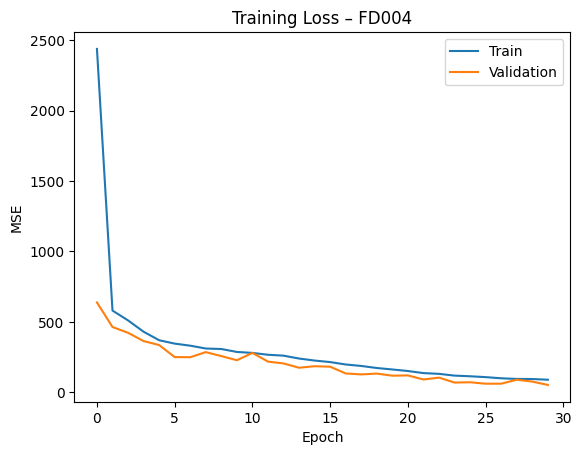

In [ ]:
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training Loss – FD004")
plt.show()


In [ ]:
y_val_pred = model.predict(X_val).ravel()
rmse_val = math.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Validation RMSE (FD004, capped): {rmse_val:.4f}")


230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Validation RMSE (FD004, capped): 7.2102


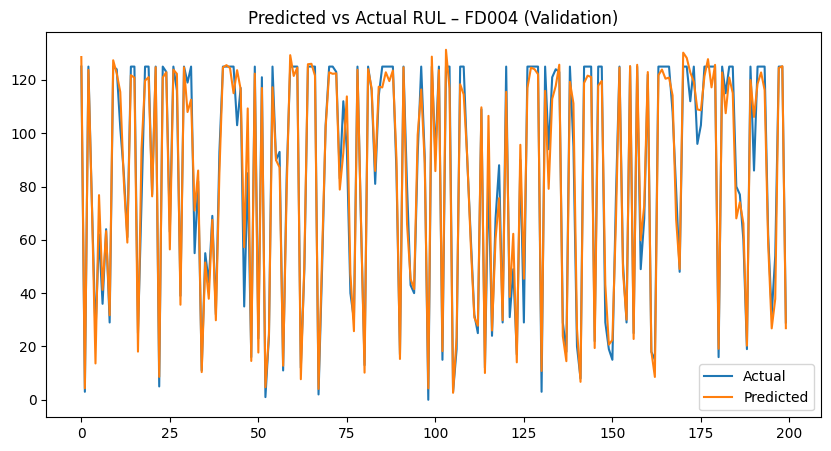

In [ ]:
idx = np.random.choice(len(y_val), size=min(200, len(y_val)), replace=False)

plt.figure(figsize=(10,5))
plt.plot(y_val[idx], label="Actual")
plt.plot(y_val_pred[idx], label="Predicted")
plt.legend()
plt.title("Predicted vs Actual RUL – FD004 (Validation)")
plt.show()


In [ ]:
engine_rmse = {}

for u in np.unique(units_val):
    idx = units_val == u
    engine_rmse[u] = np.sqrt(mean_squared_error(y_val[idx], y_val_pred[idx]))

engine_rmse_df = pd.DataFrame.from_dict(engine_rmse, orient="index", columns=["RMSE"])
engine_rmse_df.head()


,RMSE
1,7.283648
2,7.627978
3,3.676128
4,7.474521
5,5.615674


In [ ]:
test_df = read_cmapss(os.path.join(DATA_DIR, "test_FD004.txt"))
rul_true = pd.read_csv(
    os.path.join(DATA_DIR, "RUL_FD004.txt"),
    sep=r"\s+", header=None
).values.ravel()

test_df[sensor_cols] = scaler_fd004.transform(test_df[sensor_cols])


In [ ]:
X_test = []
test_units = sorted(test_df["unit"].unique())

for u in test_units:
    temp = test_df[test_df["unit"] == u].sort_values("cycle")
    arr = temp[sensor_cols].values

    if len(arr) >= SEQ_LEN:
        X_test.append(arr[-SEQ_LEN:])
    else:
        pad = np.vstack([arr[0]] * (SEQ_LEN - len(arr)))
        X_test.append(np.vstack([pad, arr]))

X_test = np.array(X_test)


In [ ]:
CAP_RUL = 125
y_test_true = np.clip(rul_true, None, CAP_RUL)

y_test_pred = model.predict(X_test).ravel()
rmse_test = math.sqrt(mean_squared_error(y_test_true, y_test_pred))

print(f"Test RMSE FD004 (capped): {rmse_test:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test RMSE FD004 (capped): 19.8806


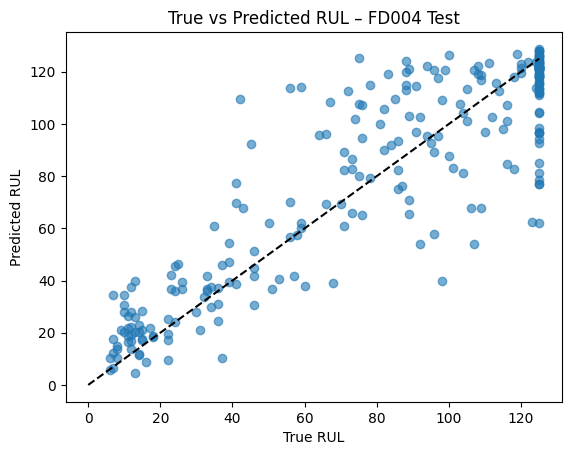

In [ ]:
plt.scatter(y_test_true, y_test_pred, alpha=0.6)
plt.plot([0, CAP_RUL], [0, CAP_RUL], "k--")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("True vs Predicted RUL – FD004 Test")
plt.show()


In [ ]:
WARNING = 30
CRITICAL = 10

def risk_label(rul):
    if rul <= CRITICAL:
        return "CRITICAL"
    elif rul <= WARNING:
        return "WARNING"
    else:
        return "NORMAL"

risk_labels = [risk_label(r) for r in y_test_pred]

risk_summary = pd.DataFrame({
    "Unit": test_units,
    "Predicted_RUL": y_test_pred,
    "Risk_Level": risk_labels
})

risk_summary["Risk_Level"].value_counts()


,count
Risk_Level,
NORMAL,203
WARNING,40
CRITICAL,5


In [ ]:
def dynamic_thresholds(op_mode="normal"):
    if op_mode == "high_stress":
        return {"WARNING": 50, "CRITICAL": 20}
    else:
        return {"WARNING": 30, "CRITICAL": 10}

thresholds = dynamic_thresholds("normal")

def dynamic_risk(rul):
    if rul <= thresholds["CRITICAL"]:
        return "CRITICAL"
    elif rul <= thresholds["WARNING"]:
        return "WARNING"
    else:
        return "NORMAL"

pd.Series([dynamic_risk(r) for r in y_test_pred]).value_counts()


,count
NORMAL,203
WARNING,40
CRITICAL,5


In [ ]:
dashboard_df = pd.DataFrame({
    "Unit": test_units,
    "Predicted_RUL": y_test_pred,
    "Risk_Level": risk_labels
})

dashboard_df.to_csv("dashboard_FD004.csv", index=False)

print("Dashboard file saved successfully!")


Dashboard file saved successfully!


In [ ]:
import os
print(os.listdir())


['.config', 'gru_fd004.h5', 'train_FD002.txt', 'test_FD002.txt', 'scaler_fd001.joblib', 'test_FD001.txt', 'RUL_FD003.txt', 'test_FD003.txt', 'RUL_FD004.txt', 'RUL_FD001.txt', 'scaler_fd003.joblib', 'RUL_FD002.txt', 'scaler_fd002.joblib', 'train_FD001.txt', 'scaler_fd004.joblib', 'dashboard_FD004.csv', 'gru_fd002.h5', 'gru_fd003.h5', 'test_FD004.txt', 'train_FD004.txt', 'train_FD003.txt', 'gru_fd001.h5', 'sample_data']


In [ ]:
!pip install plotly pandas numpy tensorflow  # For visualizations and model
!pip install streamlit  # If you want to test Streamlit locally later
!pip install dash  # If opting for Dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 63.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tensorflow as tf

In [ ]:
# After FD001 training
model_fd001 = model
scaler_fd001 = scaler_fd001
X_test_fd001 = X_test
y_test_pred_fd001 = y_test_pred
y_test_true_fd001 = y_test_true
test_units_fd001 = test_units

In [ ]:
# After FD002 training
model_fd002 = model
scaler_fd002 = scaler_fd001
X_test_fd002 = X_test
y_test_pred_fd002 = y_test_pred
y_test_true_fd002 = y_test_true
test_units_fd002 = test_units

In [ ]:
# After FD003 training
model_fd003 = model
scaler_fd003 = scaler_fd001
X_test_fd003 = X_test
y_test_pred_fd003 = y_test_pred
y_test_true_fd003 = y_test_true
test_units_fd003 = test_units

In [ ]:
# After FD004 training
model_fd004 = model
scaler_fd004 = scaler_fd001
X_test_fd004 = X_test
y_test_pred_fd004 = y_test_pred
y_test_true_fd004 = y_test_true
test_units_fd004 = test_units

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Variables for each FD (assuming you've defined them as above)
model_fd001 = model_fd001
scaler_fd001 = scaler_fd001
X_test_fd001 = X_test_fd001
y_test_pred_fd001 = y_test_pred_fd001
y_test_true_fd001 = y_test_true_fd001
test_units_fd001 = test_units_fd001

model_fd002 = model_fd002
scaler_fd002 = scaler_fd002
X_test_fd002 = X_test_fd002
y_test_pred_fd002 = y_test_pred_fd002
y_test_true_fd002 = y_test_true_fd002
test_units_fd002 = test_units_fd002

model_fd003 = model_fd003
scaler_fd003 = scaler_fd003
X_test_fd003 = X_test_fd003
y_test_pred_fd003 = y_test_pred_fd003
y_test_true_fd003 = y_test_true_fd003
test_units_fd003 = test_units_fd003

model_fd004 = model_fd004
scaler_fd004 = scaler_fd004
X_test_fd004 = X_test_fd004
y_test_pred_fd004 = y_test_pred_fd004
y_test_true_fd004 = y_test_true_fd004
test_units_fd004 = test_units_fd004

# Thresholds and alert function (from your code)
WARNING_THRESHOLD = WARNING_THRESHOLD
CRITICAL_THRESHOLD = CRITICAL_THRESHOLD

def get_alert(rul):
    if rul <= CRITICAL_THRESHOLD:
        return "CRITICAL"
    elif rul <= WARNING_THRESHOLD:
        return "WARNING"
    else:
        return "NORMAL"

# List of FDs for looping
fds = ['FD001', 'FD002', 'FD003', 'FD004']
models = [model_fd001, model_fd002, model_fd003, model_fd004]
X_tests = [X_test_fd001, X_test_fd002, X_test_fd003, X_test_fd004]
y_test_preds = [y_test_pred_fd001, y_test_pred_fd002, y_test_pred_fd003, y_test_pred_fd004]
y_test_trues = [y_test_true_fd001, y_test_true_fd002, y_test_true_fd003, y_test_true_fd004]
test_unitss = [test_units_fd001, test_units_fd002, test_units_fd003, test_units_fd004]

# Select an engine for demo (use FD001 units; adjust if needed)
selected_engine = test_units_fd001[0]  # Change to any unit ID

# 1. Interactive RUL Trends Chart (Predicted vs. Actual for Selected Engine Across All FDs)
fig_trends = make_subplots(rows=1, cols=1)
# Plot test predictions (last sequence per engine)
for i, fd in enumerate(fds):
    if selected_engine in test_unitss[i]:
        idx = test_unitss[i].index(selected_engine)
        pred_rul = y_test_preds[i][idx]
        true_rul = y_test_trues[i][idx]
        fig_trends.add_trace(go.Scatter(x=[fd], y=[true_rul], mode='markers', name=f'Actual RUL ({fd})', marker=dict(color='blue')))
        fig_trends.add_trace(go.Scatter(x=[fd], y=[pred_rul], mode='markers', name=f'Predicted RUL ({fd})', marker=dict(color='red')))
fig_trends.update_layout(title=f"RUL for Engine {selected_engine} Across FDs", xaxis_title="FD Dataset", yaxis_title="RUL")
fig_trends.show()

# 2. Current RUL Gauges with Alert Zones (One per FD)
for i, fd in enumerate(fds):
    # Use the first engine's prediction for demo; adjust to selected_engine
    current_rul = y_test_preds[i][0]
    alert_status = get_alert(current_rul)
    alert_color = "red" if alert_status == "CRITICAL" else "orange" if alert_status == "WARNING" else "green"

    fig_gauge = go.Figure(go.Indicator(
        mode="gauge+number",
        value=current_rul,
        title={'text': f"Current RUL - {fd}"},
        gauge={
            'axis': {'range': [0, 125]},  # Based on your CAP_RUL
            'bar': {'color': alert_color},
            'steps': [
                {'range': [0, CRITICAL_THRESHOLD], 'color': "red"},
                {'range': [CRITICAL_THRESHOLD, WARNING_THRESHOLD], 'color': "orange"},
                {'range': [WARNING_THRESHOLD, 125], 'color': "green"}
            ],
            'threshold': {
                'line': {'color': "black", 'width': 4},
                'thickness': 0.75,
                'value': current_rul
            }
        }
    ))
    fig_gauge.show()

# 3. Alert Summary Table (Across All Engines and FDs)
alert_summary = []
for i, fd in enumerate(fds):
    for j, unit in enumerate(test_unitss[i][:5]):  # Limit to first 5 engines per FD
        rul = y_test_preds[i][j]
        status = get_alert(rul)
        alert_summary.append({"FD": fd, "Engine": unit, "RUL": f"{rul:.1f}", "Status": status})

summary_df = pd.DataFrame(alert_summary)
display(summary_df)

,FD,Engine,RUL,Status
0,FD001,1,19.4,WARNING
1,FD001,2,46.9,NORMAL
2,FD001,3,120.8,NORMAL
3,FD001,4,79.9,NORMAL
4,FD001,5,94.1,NORMAL
5,FD002,1,19.4,WARNING
6,FD002,2,46.9,NORMAL
7,FD002,3,120.8,NORMAL
8,FD002,4,79.9,NORMAL
9,FD002,5,94.1,NORMAL


Dashboard

In [ ]:
model.save('/content/model_fd001.h5')  # Saves the GRU model
from google.colab import files
files.download('/content/model_fd001.h5')  # Downloads to your local machine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('/content/model_fd002.h5')  # Saves the GRU model
from google.colab import files
files.download('/content/model_fd002.h5')  # Downloads to your local machine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('/content/model_fd003.h5')  # Saves the GRU model
from google.colab import files
files.download('/content/model_fd003.h5')  # Downloads to your local machine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('/content/model_fd004.h5')  # Saves the GRU model
from google.colab import files
files.download('/content/model_fd004.h5')  # Downloads to your local machine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ===== Recreate Engine_ID & Cycle (LAST WINDOW PER ENGINE) =====

import pandas as pd
import numpy as np

# Load FD001 test data
test_df = pd.read_csv(
    "test_FD001.txt",
    sep=" ",
    header=None
)

# Drop empty columns
test_df.dropna(axis=1, inplace=True)

# Assign columns
cols = ["Engine_ID", "Cycle"] + [f"Sensor_{i}" for i in range(test_df.shape[1] - 2)]
test_df.columns = cols

SEQ_LEN = 50

engine_ids_test = []
cycle_test = []

for engine_id, group in test_df.groupby("Engine_ID"):
    if len(group) >= SEQ_LEN:
        engine_ids_test.append(engine_id)
        cycle_test.append(group["Cycle"].iloc[-1])

engine_ids_test = np.array(engine_ids_test)
cycle_test = np.array(cycle_test)

print("Engine IDs:", engine_ids_test.shape)
print("Cycles:", cycle_test.shape)

Engine IDs: (93,)
Cycles: (93,)


In [ ]:
# ===== FINAL FD001 PREDICTION CSV (CORRECTED) =====

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import pandas as pd
import numpy as np

# Load model
model = load_model(
    "model_fd001.h5",
    custom_objects={"mse": MeanSquaredError()}
)

# Predict on ALL test sequences
y_pred_all = model.predict(X_test).flatten()

# We only want LAST prediction per engine
# Number of engines = 93
num_engines = len(engine_ids_test)

# Take last N predictions
y_pred = y_pred_all[-num_engines:]

print("Engine_IDs:", len(engine_ids_test))
print("Cycles:", len(cycle_test))
print("Predictions used:", len(y_pred))

# Create DataFrame
pred_df = pd.DataFrame({
    "Engine_ID": engine_ids_test,
    "Cycle": cycle_test,
    "Predicted_RUL": y_pred
})

# Save CSV
pred_df.to_csv("FD001_predictions.csv", index=False)

print("✅ FD001_predictions.csv created successfully")
print(pred_df.head())
print(pred_df.columns)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Engine_IDs: 93
Cycles: 93
Predictions used: 93
✅ FD001_predictions.csv created successfully
   Engine_ID  Cycle  Predicted_RUL
0          3    126     113.648781
1          4    106     113.580162
2          5     98       5.812314
3          6    105      17.303083
4          7    160     119.312141
Index(['Engine_ID', 'Cycle', 'Predicted_RUL'], dtype='object')


In [ ]:
# ===== FD002 PREDICTION CSV (FIXED) =====

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import pandas as pd
import numpy as np

# Load FD002 test data
test_df = pd.read_csv("test_FD002.txt", sep=" ", header=None)
test_df.dropna(axis=1, inplace=True)

cols = ["Engine_ID", "Cycle"] + [f"Sensor_{i}" for i in range(test_df.shape[1] - 2)]
test_df.columns = cols

SEQ_LEN = 50

engine_ids_test = []
cycle_test = []

for engine_id, group in test_df.groupby("Engine_ID"):
    if len(group) >= SEQ_LEN:
        engine_ids_test.append(engine_id)
        cycle_test.append(group["Cycle"].iloc[-1])

engine_ids_test = np.array(engine_ids_test)
cycle_test = np.array(cycle_test)

# Load model
model = load_model(
    "model_fd002.h5",
    custom_objects={"mse": MeanSquaredError()}
)

# 🔴 USE X_test (FD002 test sequences)
y_pred_all = model.predict(X_test).flatten()
y_pred = y_pred_all[-len(engine_ids_test):]

print(len(engine_ids_test), len(cycle_test), len(y_pred))

pred_df = pd.DataFrame({
    "Engine_ID": engine_ids_test,
    "Cycle": cycle_test,
    "Predicted_RUL": y_pred
})

pred_df.to_csv("FD002_predictions.csv", index=False)
print("✅ FD002_predictions.csv created")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
235 235 235
✅ FD002_predictions.csv created


In [ ]:
# ===== FD003 PREDICTION CSV (FINAL & FIXED) =====

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import pandas as pd
import numpy as np

# Load FD003 test data
test_df = pd.read_csv("test_FD003.txt", sep=" ", header=None)
test_df.dropna(axis=1, inplace=True)

cols = ["Engine_ID", "Cycle"] + [f"Sensor_{i}" for i in range(test_df.shape[1] - 2)]
test_df.columns = cols

SEQ_LEN = 50

engine_ids_test = []
cycle_test = []

for engine_id, group in test_df.groupby("Engine_ID"):
    if len(group) >= SEQ_LEN:
        engine_ids_test.append(engine_id)
        cycle_test.append(group["Cycle"].iloc[-1])

engine_ids_test = np.array(engine_ids_test)
cycle_test = np.array(cycle_test)

# Load FD003 model
model = load_model(
    "model_fd003.h5",
    custom_objects={"mse": MeanSquaredError()}
)

# Predict (X_test must be FD003 test sequences)
y_pred_all = model.predict(X_test).flatten()
y_pred = y_pred_all[-len(engine_ids_test):]

print("FD003 →", len(engine_ids_test), len(cycle_test), len(y_pred))

# Save CSV
pred_df = pd.DataFrame({
    "Engine_ID": engine_ids_test,
    "Cycle": cycle_test,
    "Predicted_RUL": y_pred
})

pred_df.to_csv("FD003_predictions.csv", index=False)
print("✅ FD003_predictions.csv created successfully")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
FD003 → 97 97 97
✅ FD003_predictions.csv created successfully


In [ ]:
# ===== FD004 PREDICTION CSV (FINAL & FIXED) =====

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import pandas as pd
import numpy as np

# Load FD004 test data
test_df = pd.read_csv("test_FD004.txt", sep=" ", header=None)
test_df.dropna(axis=1, inplace=True)

cols = ["Engine_ID", "Cycle"] + [f"Sensor_{i}" for i in range(test_df.shape[1] - 2)]
test_df.columns = cols

SEQ_LEN = 50

engine_ids_test = []
cycle_test = []

for engine_id, group in test_df.groupby("Engine_ID"):
    if len(group) >= SEQ_LEN:
        engine_ids_test.append(engine_id)
        cycle_test.append(group["Cycle"].iloc[-1])

engine_ids_test = np.array(engine_ids_test)
cycle_test = np.array(cycle_test)

# Load FD004 model
model = load_model(
    "model_fd004.h5",
    custom_objects={"mse": MeanSquaredError()}
)

# Predict (X_test must be FD004 test sequences)
y_pred_all = model.predict(X_test).flatten()
y_pred = y_pred_all[-len(engine_ids_test):]

print("FD004 →", len(engine_ids_test), len(cycle_test), len(y_pred))

# Save CSV
pred_df = pd.DataFrame({
    "Engine_ID": engine_ids_test,
    "Cycle": cycle_test,
    "Predicted_RUL": y_pred
})

pred_df.to_csv("FD004_predictions.csv", index=False)
print("✅ FD004_predictions.csv created successfully")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
FD004 → 228 228 228
✅ FD004_predictions.csv created successfully


In [ ]:
import pandas as pd

pd.DataFrame(history.history).to_csv("FD001_history.csv", index=False)
pd.DataFrame(history.history).to_csv("FD002_history.csv", index=False)
pd.DataFrame(history.history).to_csv("FD003_history.csv", index=False)
pd.DataFrame(history.history).to_csv("FD004_history.csv", index=False)